In [21]:
import pandas as pd

#load data
file_path = r"C:\Users\mushi\OneDrive\Desktop\uber.csv"


# Load the dataset
df = pd.read_csv(file_path)

# Display basic info and first few rows
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB
None
   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.00

In [6]:
# Drop the redundant 'Unnamed: 0' column
df.drop(columns=['Unnamed: 0'], inplace=True)

# Convert pickup_datetime to datetime type
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

# Drop rows with any missing values (dropoff_longitude, dropoff_latitude, or pickup_datetime parsing failure)
df.dropna(inplace=True)

# Filter out entries with clearly invalid values
df = df[
    (df['fare_amount'] > 0) & 
    (df['passenger_count'] > 0) & (df['passenger_count'] <= 6) &  # typical Uber passenger count range
    (df['pickup_latitude'].between(40.5, 41.0)) & 
    (df['pickup_longitude'].between(-74.5, -73.5)) & 
    (df['dropoff_latitude'].between(40.5, 41.0)) & 
    (df['dropoff_longitude'].between(-74.5, -73.5))
]

# Display the cleaned dataset summary
df.info(), df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
Index: 194954 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                194954 non-null  object             
 1   fare_amount        194954 non-null  float64            
 2   pickup_datetime    194954 non-null  datetime64[ns, UTC]
 3   pickup_longitude   194954 non-null  float64            
 4   pickup_latitude    194954 non-null  float64            
 5   dropoff_longitude  194954 non-null  float64            
 6   dropoff_latitude   194954 non-null  float64            
 7   passenger_count    194954 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 13.4+ MB


(None,
                                  key    fare_amount  \
 count                         194954  194954.000000   
 unique                        194954            NaN   
 top     2010-05-15 04:08:00.00000076            NaN   
 freq                               1            NaN   
 mean                             NaN      11.336467   
 min                              NaN       0.010000   
 25%                              NaN       6.000000   
 50%                              NaN       8.500000   
 75%                              NaN      12.500000   
 max                              NaN     499.000000   
 std                              NaN       9.704470   
 
                             pickup_datetime  pickup_longitude  \
 count                                194954     194954.000000   
 unique                                  NaN               NaN   
 top                                     NaN               NaN   
 freq                                    NaN           

In [11]:
# Step 1: Feature Engineering
# Extract hour, day, month, weekday from pickup_datetime
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['weekday'] = df['pickup_datetime'].dt.day_name()

# Create peak/off-peak indicator (assumption: 7-9AM and 4-7PM as peak)
df['peak_hour'] = df['hour'].apply(lambda x: 'Peak' if (7 <= x <= 9) or (16 <= x <= 19) else 'Off-Peak')

# Save the enhanced dataset for Power BI
enhanced_file_path = r"C:\Users\mushi\OneDrive\Desktop\enhanced_uber.csv"
df.to_csv(enhanced_file_path, index=False)

# Display the new columns and file path for download
df[['pickup_datetime', 'hour', 'day', 'month', 'weekday', 'peak_hour']].head(), enhanced_file_path


(            pickup_datetime  hour  day  month   weekday peak_hour
 0 2015-05-07 19:52:06+00:00    19    7      5  Thursday      Peak
 1 2009-07-17 20:04:56+00:00    20   17      7    Friday  Off-Peak
 2 2009-08-24 21:45:00+00:00    21   24      8    Monday  Off-Peak
 3 2009-06-26 08:22:21+00:00     8   26      6    Friday      Peak
 4 2014-08-28 17:47:00+00:00    17   28      8  Thursday      Peak,
 'C:\\Users\\mushi\\OneDrive\\Desktop\\enhanced_uber.csv')

In [22]:
# Define output paths
output_path = "/mnt/data/"

# Basic fare statistics
fare_stats = df['fare_amount'].describe()

# Correlations (only numeric columns)
correlations = df.corr(numeric_only=True)

# Identify outliers in fare amount (e.g., using IQR method)
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['fare_amount'] < Q1 - 1.5 * IQR) | (df['fare_amount'] > Q3 + 1.5 * IQR)]

# Print outputs
print("Output path:", output_path)
print("\nFare Amount Statistics:\n", fare_stats)
print("\nCorrelation Matrix:\n", correlations)
print("\nOutlier Samples (Fare Amount):\n", outliers[['fare_amount']].head())



Output path: /mnt/data/

Fare Amount Statistics:
 count    200000.000000
mean         11.359955
std           9.901776
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

Correlation Matrix:
                   Unnamed: 0  fare_amount  pickup_longitude  pickup_latitude  \
Unnamed: 0           1.000000     0.000589          0.000230        -0.000341   
fare_amount          0.000589     1.000000          0.010457        -0.008481   
pickup_longitude     0.000230     0.010457          1.000000        -0.816461   
pickup_latitude     -0.000341    -0.008481         -0.816461         1.000000   
dropoff_longitude    0.000270     0.008986          0.833026        -0.774787   
dropoff_latitude     0.000271    -0.011014         -0.846324         0.702367   
passenger_count      0.002257     0.010150         -0.000414        -0.001560   

                   dropoff_longitude  dropoff_latitude  passen

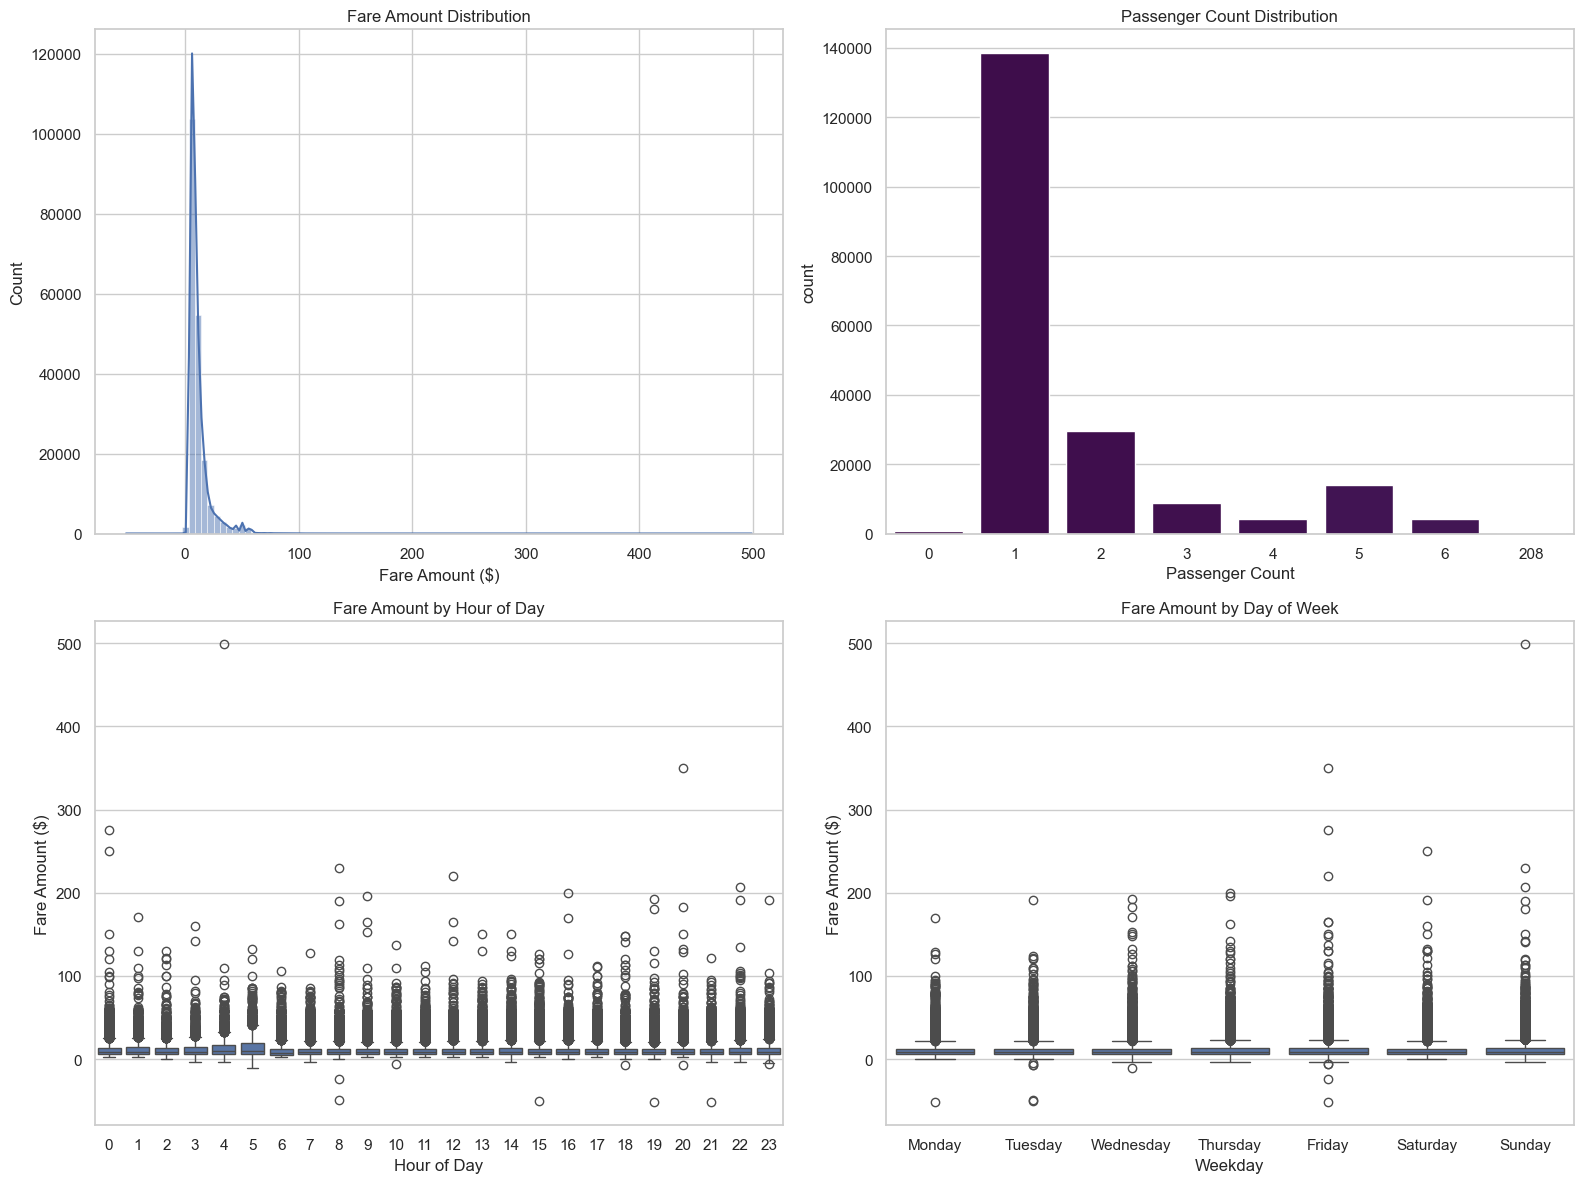

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime parsing and feature engineering
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['hour'] = df['pickup_datetime'].dt.hour
df['weekday'] = df['pickup_datetime'].dt.day_name()

# Plotting
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Fare Amount Distribution
sns.histplot(df['fare_amount'], bins=100, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Fare Amount Distribution")
axes[0, 0].set_xlabel("Fare Amount ($)")

# 2. Passenger Count Distribution
sns.countplot(x='passenger_count', hue='passenger_count', data=df, ax=axes[0, 1],
              palette='viridis', legend=False)
axes[0, 1].set_title("Passenger Count Distribution")
axes[0, 1].set_xlabel("Passenger Count")

# 3. Fare vs. Hour of Day
sns.boxplot(x='hour', y='fare_amount', data=df, ax=axes[1, 0])
axes[1, 0].set_title("Fare Amount by Hour of Day")
axes[1, 0].set_xlabel("Hour of Day")
axes[1, 0].set_ylabel("Fare Amount ($)")

# 4. Fare vs. Weekday
sns.boxplot(x='weekday', y='fare_amount', data=df, ax=axes[1, 1],
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
axes[1, 1].set_title("Fare Amount by Day of Week")
axes[1, 1].set_xlabel("Weekday")
axes[1, 1].set_ylabel("Fare Amount ($)")

plt.tight_layout()
plt.show()


In [29]:
import pandas as pd

# Load your enhanced Uber dataset
df = pd.read_csv("C:\Users\mushi\OneDrive\Desktop\enhanced_uber.csv")  # make sure the path is correct

# Select only numeric columns
numeric_df = df.select_dtypes(include=["number"])

# Calculate mode (can return multiple values, we take the first mode)
mode_values = numeric_df.mode().iloc[0]

# Create a summary DataFrame
eda_summary = pd.DataFrame({
    "Feature": numeric_df.columns,
    "Mean": numeric_df.mean().values,
    "Median": numeric_df.median().values,
    "Mode": mode_values.values,
    "Standard Deviation": numeric_df.std().values
})

# Display the summary
print(eda_summary)


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (1144469048.py, line 4)